In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [108]:
ls

__notebook_source__.ipynb  my_model_weights.npy


In [109]:
import csv
from matplotlib import pyplot as plt
import numpy as np

reshape_size = (48,48)
def GetData(filename):
    X = []
    Y = []
    with open(filename) as csv_file:
        f = 0
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if f == 0 :
                print(row)
                f = 1
            elif f == 1:
                pixels = np.fromstring(row[1], dtype=int, sep=' ')
                pixels = pixels.reshape( reshape_size )
                emotion = int(row[0])

                X.append(pixels)
                Y.append(emotion)
    return [X,Y]

In [110]:
[train_X, train_Y] = GetData('../input/train.csv')
train_X = np.array(train_X)
train_Y = np.array(train_Y)

print('Train data shape:',train_X.shape, train_Y.shape)

['emotion', 'pixels']
Train data shape: (28709, 48, 48) (28709,)


In [111]:
[validation_X, validation_Y] = GetData('../input/val.csv')
validation_X = np.array(validation_X)
validation_Y = np.array(validation_Y)

print('Validation data shape:',validation_X.shape, validation_Y.shape)

['emotion', 'pixels']
Validation data shape: (3589, 48, 48) (3589,)


In [112]:
[test_X, test_Y] = GetData('../input/test.csv')
test_X = np.array(test_X)
test_Y = np.array(test_Y)

print('Test data shape:',test_X.shape, test_Y.shape)

['emotion', 'pixels']
Test data shape: (3589, 48, 48) (3589,)


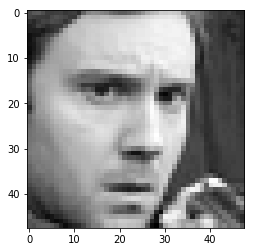

In [113]:

plt.figure(0)
plt.imshow(train_X[0], cmap = 'gray')
plt.show()

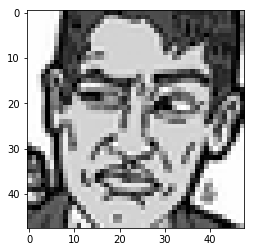

In [114]:
plt.figure(1)
plt.imshow(validation_X[0], cmap = 'gray')
plt.show()

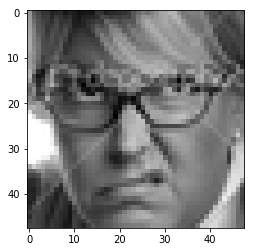

In [115]:
plt.figure(2)
plt.imshow(test_X[0], cmap = 'gray')
plt.show()

In [116]:
def ChangeTo4D(data):
    ip_shape = data.shape
    
    #ip_shape = (1,)+ip_shape
    ip_shape = (ip_shape[0],1,ip_shape[1],ip_shape[2])
    #ip_shape = ip_shape +(1,)
    return data.reshape(ip_shape)
    '''
    data_4d = np.zeros(ip_shape)
    data_4d[..., 0] = data

    print(data_4d.shape)
    print(data_4d[0].shape)
    
    return data_4d
    '''

In [117]:
train_X_4d = ChangeTo4D(train_X)
print(train_X_4d.shape)
validation_X_4d = ChangeTo4D(validation_X)
test_X_4d = ChangeTo4D(test_X)

(28709, 1, 48, 48)


In [118]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [119]:
test_Y_one_hot_encoding = keras.utils.to_categorical(test_Y);
train_Y_one_hot_encoding = keras.utils.to_categorical(train_Y);
validation_Y_one_hot_encoding = keras.utils.to_categorical(validation_Y);

In [120]:

temp_data = train_X_4d[:200]
print(temp_data.shape)

(200, 1, 48, 48)


In [121]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(train_X_4d)

In [122]:
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [123]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 48, 48)        320       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 48, 48)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 48, 48)        192       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 64, 24, 24)        18496     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 24, 24)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 24, 24)        96        
__________

In [124]:
batch_size = 128
epochs = 15
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                              factor=0.1, 
                              epsilon=0.0001, 
                              patience=1, verbose=1)

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [125]:
import scipy.ndimage

train_X_4d = train_X_4d/255
validation_X_4d = validation_X_4d/255
test_X_4d=test_X_4d/255

history = model.fit_generator(datagen.flow(train_X_4d, train_Y_one_hot_encoding, batch_size=batch_size), 
                              steps_per_epoch=train_X_4d.shape[0] // batch_size,
                              #callbacks=[lr_reduce],
                              validation_data=(validation_X_4d, validation_Y_one_hot_encoding),
                              epochs = epochs, verbose = 2)

Epoch 1/15
 - 11s - loss: 1.8137 - categorical_accuracy: 0.2344 - val_loss: 1.7816 - val_categorical_accuracy: 0.2494
Epoch 2/15
 - 9s - loss: 1.7715 - categorical_accuracy: 0.2619 - val_loss: 1.8493 - val_categorical_accuracy: 0.2491
Epoch 3/15
 - 9s - loss: 1.6755 - categorical_accuracy: 0.3278 - val_loss: 1.5625 - val_categorical_accuracy: 0.3801
Epoch 4/15
 - 10s - loss: 1.5189 - categorical_accuracy: 0.4120 - val_loss: 1.4902 - val_categorical_accuracy: 0.4149
Epoch 5/15
 - 9s - loss: 1.3986 - categorical_accuracy: 0.4586 - val_loss: 1.3222 - val_categorical_accuracy: 0.4915
Epoch 6/15
 - 9s - loss: 1.3086 - categorical_accuracy: 0.4971 - val_loss: 1.2394 - val_categorical_accuracy: 0.5174
Epoch 7/15
 - 9s - loss: 1.2476 - categorical_accuracy: 0.5250 - val_loss: 1.1932 - val_categorical_accuracy: 0.5394
Epoch 8/15
 - 9s - loss: 1.1946 - categorical_accuracy: 0.5474 - val_loss: 1.1341 - val_categorical_accuracy: 0.5603
Epoch 9/15
 - 9s - loss: 1.1521 - categorical_accuracy: 0.5639

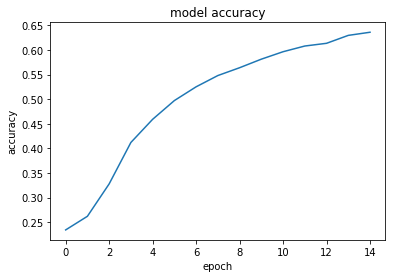

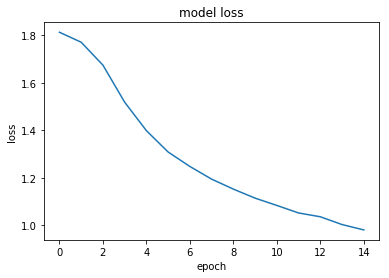

In [126]:
weights = model.get_weights()
np.save('my_model_weights', weights)
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [128]:
test_eval = model.evaluate(test_X_4d, test_Y_one_hot_encoding, verbose =1);
print('batch_size:', batch_size, 'epochs:', epochs)
print('test loss and acc is', test_eval[0], test_eval[1]);

3589/3589 [==============================] - 0s 127us/step
batch_size: 128 epochs: 15
test loss and acc is 1.0084424605107831 0.6146558930396236
